# Datathon 3.0 
### Forecasting of Dengue cases in Singapore


In [1]:
#Standard data preprocessing imports
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

First step of any data science/machine learning project is to conduct exploratory data analysis to see if there are any inherent structures or patterns in the data. This is even more important in time-series data to see if the patterns observed are cyclical, seasonal or if there are any trends within the data. For this analysis we are provided with 4 columns of data:

- Dengue Cases (Weekly Data)
- Rainfall (Daily - Geographical)
- Temperature (Daily - Geographical)
- Population (Yearly Data)


In this first section we will look at post-2012 data 

In [23]:
#Loading the Data
post2012 = []
for i in range(2012,2020):
    df = pd.read_csv("dengue-post2012/" + str(i)+ ".csv")
    df["Epidemiology Wk"]= df["Epidemiology Wk"].apply(lambda x: str(i)+ "-" +str(x))
    post2012.append(df)
post2012 = pd.concat(post2012)  
    

In [28]:
post2012

,Epidemiology Wk,dengue
0,2012-1,74
1,2012-2,66
2,2012-3,61
3,2012-4,52
4,2012-5,85
...,...,...
42,2019-43,242
43,2019-44,308
44,2019-45,322
45,2019-46,373


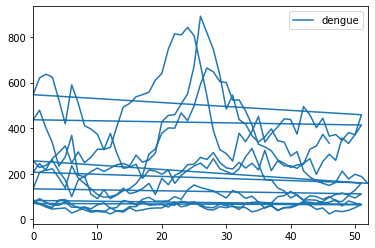

In [16]:
test = pd.read_csv("dengue-post2012/2012.csv")

In [20]:
df["Epidemiology Wk"].apply(lambda x: str(i)+ "-" +str(x))

0      2019-1
1      2019-2
2      2019-3
3      2019-4
4      2019-5
5      2019-6
6      2019-7
7      2019-8
8      2019-9
9     2019-10
10    2019-11
11    2019-12
12    2019-13
13    2019-14
14    2019-15
15    2019-16
16    2019-17
17    2019-18
18    2019-19
19    2019-20
20    2019-21
21    2019-22
22    2019-23
23    2019-24
24    2019-25
25    2019-26
26    2019-27
27    2019-28
28    2019-29
29    2019-30
30    2019-31
31    2019-32
32    2019-33
33    2019-34
34    2019-35
35    2019-36
36    2019-37
37    2019-38
38    2019-39
39    2019-40
40    2019-41
41    2019-42
42    2019-43
43    2019-44
44    2019-45
45    2019-46
46    2019-47
Name: Epidemiology Wk, dtype: object